<a href="https://colab.research.google.com/github/Prernanchan/news-stocks/blob/main/stocksentiment_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# import yahoo_fin.stock_info as si
import datetime
from datetime import date
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
# from yahoo_fin import options

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
tweetTexts = []

In [ ]:
dataSet, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataSet, test_dataSet = dataSet['train'], dataSet['test']
encoder = info.features['text'].encoder

In [ ]:
padded_shapes = ([None], ())
train_dataSet = train_dataSet.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
test_dataSet = test_dataSet.padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(encoder.vocab_size, 64),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [ ]:
fit_model = model.fit(train_dataSet, epochs=5, validation_data=test_dataSet, validation_steps=30)


Epoch 1/5
391/391 [==============================] - 1715s 4s/step - loss: 0.6441 - accuracy: 0.5975 - val_loss: 0.4694 - val_accuracy: 0.7849
Epoch 2/5
391/391 [==============================] - 1680s 4s/step - loss: 0.6798 - accuracy: 0.5668 - val_loss: 0.6898 - val_accuracy: 0.5938
Epoch 3/5
391/391 [==============================] - 1657s 4s/step - loss: 0.6087 - accuracy: 0.6991 - val_loss: 0.6003 - val_accuracy: 0.7229
Epoch 4/5
391/391 [==============================] - 1668s 4s/step - loss: 0.5301 - accuracy: 0.7850 - val_loss: 0.5363 - val_accuracy: 0.7688
Epoch 5/5
391/391 [==============================] - 1669s 4s/step - loss: 0.6461 - accuracy: 0.6407 - val_loss: 0.6853 - val_accuracy: 0.6672


In [ ]:
today = date.today()
model.save('RNN_' + str(today) + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec


def predict(post, pad):
    encoded_sample_pred_text = encoder.encode(post)
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
        encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
        predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
        return predictions

In [ ]:
sample_text = ('This movie was awesome. The acting was incredible.')
prediction_ex = predict(sample_text, pad=True)
prediction_ex

1/1 [==============================] - 2s 2s/step


array([[0.5189072]], dtype=float32)

In [ ]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers =  ['AMD', 'AMZN', 'META', 'GOOG']


In [ ]:
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, features='html.parser')
    # print(html)
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table
    # print(news_table)

In [ ]:
from datetime import datetime
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        if row.a:
            title = row.a.text
            date_data = row.td.text.split()

            if len(date_data) == 1:
                time = date_data[0]
            else:
                date = date_data[0]
                if date == 'Today':
                    today = datetime.today()
                    date = today.strftime("%b-%d-%y")
                time = date_data[1]

            parsed_data.append([ticker, date, time, title])


In [ ]:
parsed_data

[['AMD',
  'Oct-12-23',
  '09:35AM',
  'What AMD and Nvidia Stock Investors Should Know About Recent Artificial Intelligence (AI) Updates'],
 ['AMD',
  'Oct-12-23',
  '07:20AM',
  'How Global Conflict Led to a Surprising Plan to Make Apple Chips in a Desert'],
 ['AMD',
  'Oct-12-23',
  '07:00AM',
  'Advanced Micro Devices And Nvidia Just Made Big AI Moves This Week, but Nvidia Still Seems Far Ahead'],
 ['AMD', 'Oct-12-23', '06:55AM', '2 Stocks to Invest in Virtual Reality'],
 ['AMD',
  'Oct-12-23',
  '06:35AM',
  'Nvidia Is Far Behind These 3 Semiconductor Stocks In 1 Key Metric -- Is the AI Growth Stock Still a Buy?'],
 ['AMD',
  'Oct-12-23',
  '05:25AM',
  '1 Green Flag for Nvidia Stock in 2023, and 1 Red Flag'],
 ['AMD', 'Oct-12-23', '05:05AM', "3 Red Flags for Nvidia's Future"],
 ['AMD',
  'Oct-12-23',
  '05:00AM',
  'Intel CEO Needs to Land a Big Customer, and the Clock Is Ticking'],
 ['AMD',
  'Oct-11-23',
  '11:50AM',
  'AMD Expands Open AI Software Capabilities With Nod.ai Buyo

In [ ]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,Oct-12-23,09:35AM,What AMD and Nvidia Stock Investors Should Kno...
1,AMD,Oct-12-23,07:20AM,How Global Conflict Led to a Surprising Plan t...
2,AMD,Oct-12-23,07:00AM,Advanced Micro Devices And Nvidia Just Made Bi...
3,AMD,Oct-12-23,06:55AM,2 Stocks to Invest in Virtual Reality
4,AMD,Oct-12-23,06:35AM,Nvidia Is Far Behind These 3 Semiconductor Sto...


In [ ]:
dataset['Company'].describe()

count     400
unique      4
top       AMD
freq      100
Name: Company, dtype: object

In [ ]:
dataset['Compound'] = dataset['News Headline'].apply(lambda headline: float(predict(headline, pad=True)))
dataset.head()

1/1 [==============================] - 0s 34ms/step


,Company,Date,Time,News Headline,Compound
0,AMD,Oct-12-23,09:35AM,What AMD and Nvidia Stock Investors Should Kno...,0.499053
1,AMD,Oct-12-23,07:20AM,How Global Conflict Led to a Surprising Plan t...,0.496072
2,AMD,Oct-12-23,07:00AM,Advanced Micro Devices And Nvidia Just Made Bi...,0.498743
3,AMD,Oct-12-23,06:55AM,2 Stocks to Invest in Virtual Reality,0.497485
4,AMD,Oct-12-23,06:35AM,Nvidia Is Far Behind These 3 Semiconductor Sto...,0.497650


In [ ]:
def sentiment_declareation(sentiment_value):
    if sentiment_value == 0.5:
          return 'neu'
    elif 0.5 < sentiment_value <= 1.0:
          return 'pos'
    elif 0.0 < sentiment_value <= 0.5:
          return 'neg'


In [ ]:
dataset['Sentiment'] = dataset['Compound'].apply(lambda value: sentiment_declareation(value))
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date
dataset.head()


,Company,Date,Time,News Headline,Compound,Sentiment
0,AMD,2023-10-12,09:35AM,What AMD and Nvidia Stock Investors Should Kno...,0.499053,neg
1,AMD,2023-10-12,07:20AM,How Global Conflict Led to a Surprising Plan t...,0.496072,neg
2,AMD,2023-10-12,07:00AM,Advanced Micro Devices And Nvidia Just Made Bi...,0.498743,neg
3,AMD,2023-10-12,06:55AM,2 Stocks to Invest in Virtual Reality,0.497485,neg
4,AMD,2023-10-12,06:35AM,Nvidia Is Far Behind These 3 Semiconductor Sto...,0.497650,neg


In [ ]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2023-09-26  2023-10-12
AMZN     2023-10-08  2023-10-12
GOOG     2023-10-06  2023-10-12
META     2023-10-03  2023-10-12

In [ ]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2023-10-12,09:35AM,What AMD and Nvidia Stock Investors Should Kno...,0.499053,neg,2023-10-12,2023-09-26
1,AMD,2023-10-12,07:20AM,How Global Conflict Led to a Surprising Plan t...,0.496072,neg,2023-10-12,2023-09-26
2,AMD,2023-10-12,07:00AM,Advanced Micro Devices And Nvidia Just Made Bi...,0.498743,neg,2023-10-12,2023-09-26
3,AMD,2023-10-12,06:55AM,2 Stocks to Invest in Virtual Reality,0.497485,neg,2023-10-12,2023-09-26
4,AMD,2023-10-12,06:35AM,Nvidia Is Far Behind These 3 Semiconductor Sto...,0.497650,neg,2023-10-12,2023-09-26


In [ ]:
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2023-10-12,09:35AM,What AMD and Nvidia Stock Investors Should Kno...,0.499053,neg,2023-10-12,2023-09-26
1,AMD,2023-10-12,07:20AM,How Global Conflict Led to a Surprising Plan t...,0.496072,neg,2023-10-12,2023-09-26
2,AMD,2023-10-12,07:00AM,Advanced Micro Devices And Nvidia Just Made Bi...,0.498743,neg,2023-10-12,2023-09-26
3,AMD,2023-10-12,06:55AM,2 Stocks to Invest in Virtual Reality,0.497485,neg,2023-10-12,2023-09-26
4,AMD,2023-10-12,06:35AM,Nvidia Is Far Behind These 3 Semiconductor Sto...,0.497650,neg,2023-10-12,2023-09-26
...,...,...,...,...,...,...,...,...
395,GOOG,2023-10-06,03:00PM,"Google Rejects Trudeaus Olive Branch, Threaten...",0.497601,neg,2023-10-12,2023-10-06
396,GOOG,2023-10-06,01:10PM,"Google, Apple face fines in South Korea for br...",0.497798,neg,2023-10-12,2023-10-06
397,GOOG,2023-10-06,12:46PM,'You Need The Magnificent Seven': Jim Cramer S...,0.496485,neg,2023-10-12,2023-10-06
398,GOOG,2023-10-06,12:25PM,Alphabet (GOOGL) Boosts Its Smartphone Offerin...,0.496335,neg,2023-10-12,2023-10-06


In [ ]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
    if row['Company'] in company_early_late_dates:
            company_early_late_dates[row['Company']]['early'] = row['MinDate']
            company_early_late_dates[row['Company']]['late'] = row['MaxDate']
    else:
            company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2023, 9, 26),
  'late': datetime.date(2023, 10, 12)},
 'AMZN': {'early': datetime.date(2023, 10, 8),
  'late': datetime.date(2023, 10, 12)},
 'META': {'early': datetime.date(2023, 10, 3),
  'late': datetime.date(2023, 10, 12)},
 'GOOG': {'early': datetime.date(2023, 10, 6),
  'late': datetime.date(2023, 10, 12)}}

In [ ]:
pip install yahoo_fin

In [ ]:
import yahoo_fin.stock_info as si
from yahoo_fin import options
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_RNN.csv', index=False)


AMD -> {'early': datetime.date(2023, 9, 26), 'late': datetime.date(2023, 10, 12)}
AMZN -> {'early': datetime.date(2023, 10, 8), 'late': datetime.date(2023, 10, 12)}
META -> {'early': datetime.date(2023, 10, 3), 'late': datetime.date(2023, 10, 12)}
GOOG -> {'early': datetime.date(2023, 10, 6), 'late': datetime.date(2023, 10, 12)}


In [ ]:
for key, value in company_early_late_dates.items():
    print(key, '->', value)
    try:
        tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
        tmp_df['date'] = tmp_df.index
        tmp_df.to_csv(key + '_RNN.csv', index=False)
    except KeyError as e:
        print(f"Error fetching data for {key}: {e}")
        continue

AMD -> {'early': datetime.date(2023, 9, 26), 'late': datetime.date(2023, 10, 12)}
AMZN -> {'early': datetime.date(2023, 10, 8), 'late': datetime.date(2023, 10, 12)}
META -> {'early': datetime.date(2023, 10, 3), 'late': datetime.date(2023, 10, 12)}
GOOG -> {'early': datetime.date(2023, 10, 6), 'late': datetime.date(2023, 10, 12)}


In [ ]:
sentiment_result = {}
for value in dataset['Sentiment']:
    if value in sentiment_result:
        if value == 'neu':
            sentiment_result['neu'] += 1
        elif value == 'pos':
            sentiment_result['pos'] += 1
        elif value == 'neg':
            sentiment_result['neg'] += 1
    else:
        sentiment_result[value] = 1

sentiment_result

{'neg': 397, 'pos': 3}

In [ ]:
result_by_companies = {}
for index, row in dataset.iterrows():
    if row['Company'] in result_by_companies:
          if row['Sentiment'] == 'neu':
                  result_by_companies[row['Company']]['neu'] +=1
          if row['Sentiment'] == 'pos':
                  result_by_companies[row['Company']]['pos'] +=1
          if row['Sentiment'] == 'neg':
                  result_by_companies[row['Company']]['neg'] +=1
    else:
            result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 99, 'neu': 0, 'pos': 0},
 'AMZN': {'neg': 97, 'neu': 0, 'pos': 2},
 'META': {'neg': 98, 'neu': 0, 'pos': 1},
 'GOOG': {'neg': 99, 'neu': 0, 'pos': 0}}

In [ ]:
dataframe_list = []
for key, value in result_by_companies.items():
    print(key, '->', value)
    dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 99, 'neu': 0, 'pos': 0}
AMZN -> {'neg': 97, 'neu': 0, 'pos': 2}
META -> {'neg': 98, 'neu': 0, 'pos': 1}
GOOG -> {'neg': 99, 'neu': 0, 'pos': 0}


,Company,Neg,Neu,Pos
0,AMD,99,0,0
1,AMZN,97,0,2
2,META,98,0,1
3,GOOG,99,0,0


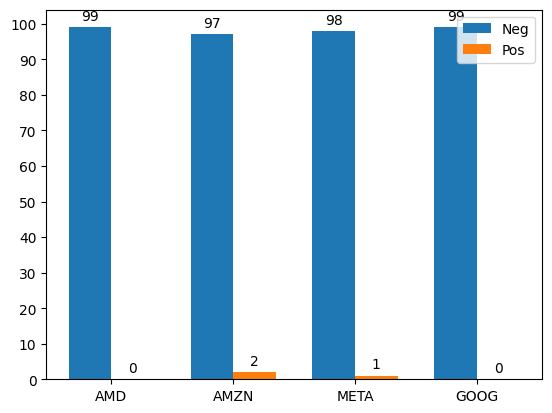

In [ ]:
index = np.arange(len(tickers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width/2, dataset_company['Neg'], bar_width, label='Neg')
barPos = ax.bar(index + bar_width/2, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(tickers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
      for bar in bars:
        bar_height = bar.get_height()
        ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barPos)

plt.show()

In [ ]:
mean_df = dataset.groupby(['Company', 'Date']).mean()
mean_df

<ipython-input-59-580b83ba3828>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_df = dataset.groupby(['Company', 'Date']).mean()


Compound
Company Date                
AMD     2023-09-26  0.497226
        2023-09-27  0.498379
        2023-09-28  0.497692
        2023-09-29  0.498046
        2023-09-30  0.497913
        2023-10-01  0.498021
        2023-10-02  0.497985
        2023-10-03  0.497352
        2023-10-04  0.497695
        2023-10-05  0.497855
        2023-10-06  0.497152
        2023-10-08  0.497685
        2023-10-09  0.497980
        2023-10-10  0.498374
        2023-10-11  0.498206
        2023-10-12  0.497186
AMZN    2023-10-08  0.498344
        2023-10-09  0.497591
        2023-10-10  0.497882
        2023-10-11  0.498066
        2023-10-12  0.497334
GOOG    2023-10-06  0.497226
        2023-10-07  0.497125
        2023-10-08  0.497954
        2023-10-09  0.497392
        2023-10-10  0.497575
        2023-10-11  0.497721
        2023-10-12  0.497691
META    2023-10-03  0.497855
        2023-10-04  0.498123
        2023-10-05  0.497646
        2023-10-06  0.497642
        2023-10-07  0.497509
        2023-10-08  0.497164
        2023-10-09  0.497350
        2023-10-10  0.497825
        2023-10-11  0.497432
        2023-10-12  0.496760

<Axes: xlabel='Date'>

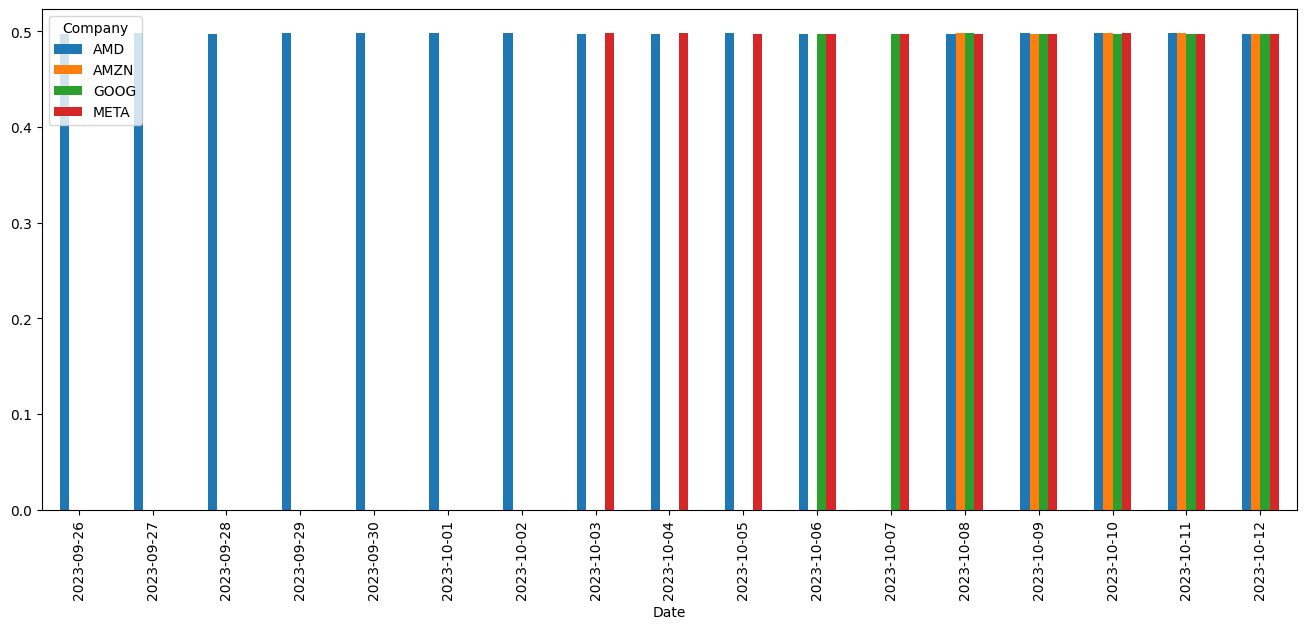

In [ ]:
mean_df = mean_df.unstack()
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(16.2, 6.5))

In [ ]:
def percentage(part, whole):
          temp = 100 * float(part) / float(whole)
          return format(temp, '.2f')

In [ ]:
def visualization(positive, neutral, negative):
        labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
                'Negative [' + str(negative) + '%]']
        sizes = [positive, neutral, negative]
        colors = ['lightgreen', 'gold', 'red']
        patches, texts = plt.pie(sizes, colors=colors, startangle=90)
        plt.title('Aggregate sentiment value of the economic news headlines')
        plt.legend(patches, labels, loc="best")
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

In [ ]:
def company_specific_sentiment_visualization(company_name):
  company_df = dataset[dataset['Company'] == company_name]
  temp = company_df.groupby(['Company', 'Date']).mean()
  temp= temp.unstack()
  temp = temp.xs('Compound', axis='columns').transpose()
  temp.plot(kind='line', figsize=(16.2, 6.5))


def company_specific_sentiment_and_stockclose_day_focus_visualization(company_name, company_stock_dataframe):
  company_specific = dataset[dataset['Company'] == company_name]
  temp_company = company_specific.groupby(['Company', 'Date']).mean()
  temp_company.to_csv(company_name + '_SentimentAndValueOnDays.csv')

  temp_dataframe = pd.read_csv("/content/" + company_name + "_SentimentAndValueOnDays.csv")
  temp_dataframe['Adj Close'] = temp_dataframe.Date.map(company_stock_dataframe.set_index('Date')['Adj Close'].to_dict())
  temp_dataframe = temp_dataframe.dropna(subset=['Adj Close'])
  return temp_dataframe

def company_compound_adjclose_normalized(company_name, company_combinated_dataframe):
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()

  plt.figure(figsize=(16.2, 6.5))
  plt.title(company_name + ': Normalized AdjClose values with Compounds')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['Compound'], label='Compound')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['Adj Close'], label='Adj Close')
  plt.xticks(rotation=70)
  plt.xlabel('Date')
  plt.ylabel('Compound')
  plt.legend()
  plt.show()

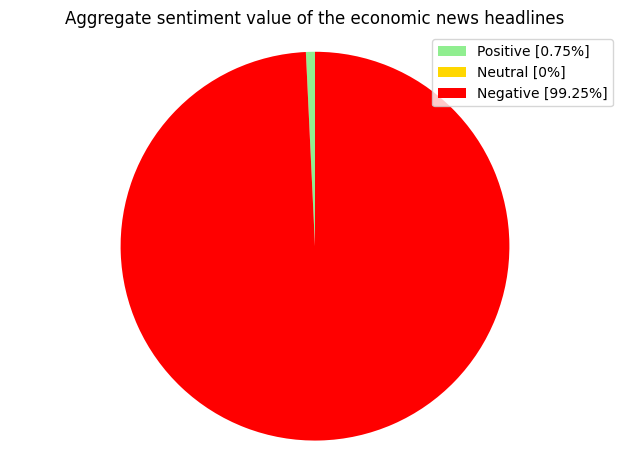

In [ ]:
all_num = sentiment_result['pos'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=0, negative=neg_percent)

In [ ]:
import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
amzn_stock = pd.read_csv("/content/drive/My Drive/Stock/AMZN_stock_data.csv")
amd_stock = pd.read_csv("/content/drive/My Drive/Stock/AMD_stock_data.csv")
# meta_stock = pd.read_csv("/content/drive/My Drive/Stock/META_stock_data.csv")
goog_stock = pd.read_csv("/content/drive/My Drive/Stock/GOOG_stock_data.csv")


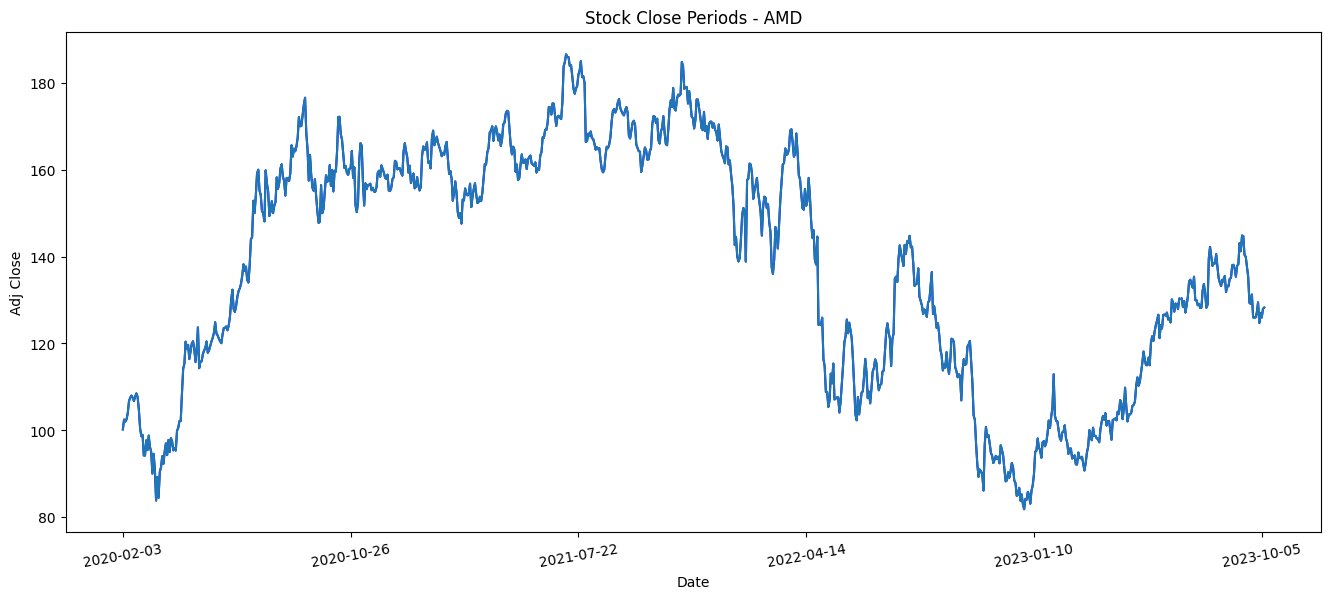

In [ ]:
date_indices = range(0, len(amzn_stock['Date']), len(amd_stock['Date']) // 5)

plt.figure(figsize=(16.2, 6.5))
plt.title('Stock Close Periods - AMD')
plt.plot(amzn_stock['Adj Close'], label='AMD', color='blue')
x = amzn_stock['Date']
y = amzn_stock['Adj Close']
plt.plot(x, y)
plt.xticks(date_indices, [x[i] for i in date_indices], rotation=10)  # Set x-axis tick positions and labels
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.show()


<ipython-input-87-16c0a6c8c127>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = company_df.groupby(['Company', 'Date']).mean()


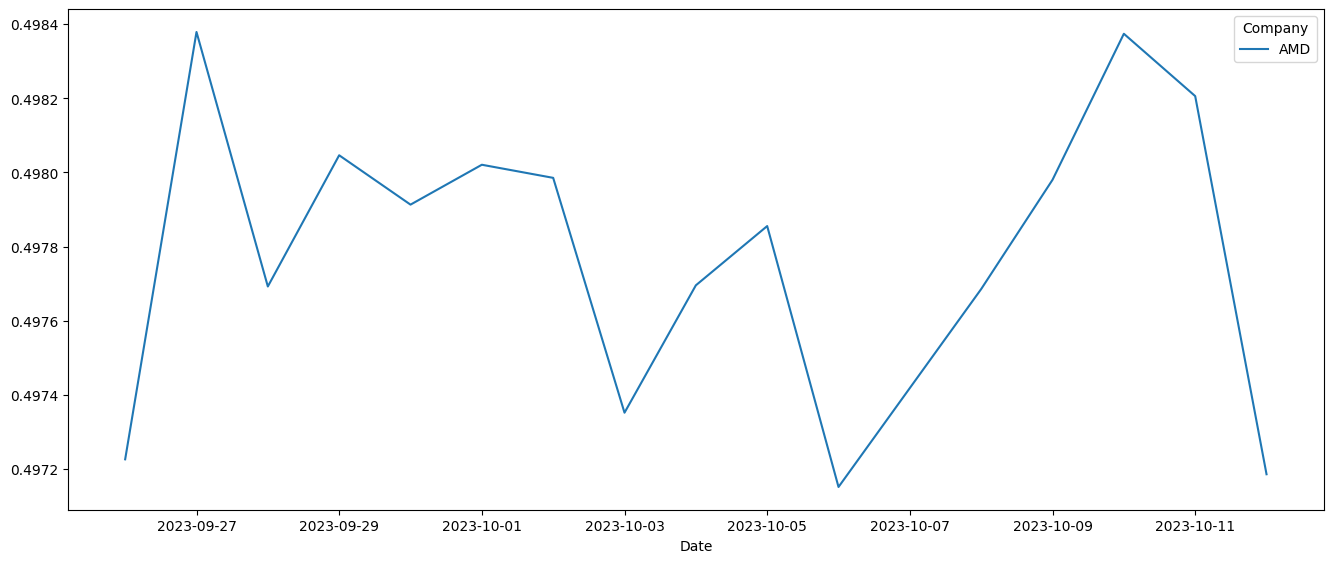

In [ ]:
company_specific_sentiment_visualization('AMD')

In [ ]:
AMD_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMD', amd_stock)
AMD_combinated_dataframe.head()

<ipython-input-87-16c0a6c8c127>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_company = company_specific.groupby(['Company', 'Date']).mean()


,Company,Date,Compound,Adj Close
0,AMD,2023-09-26,0.497,95.960
1,AMD,2023-09-27,0.498,98.070
2,AMD,2023-09-28,0.498,102.760
3,AMD,2023-09-29,0.498,102.820
6,AMD,2023-10-02,0.498,103.270


In [ ]:
amd_combinated_dataframe = company_specific_sentiment_and_stockclose_day_focus_visualization('AMD', amd_stock)
amd_combinated_dataframe

<ipython-input-120-23d6c74fb28e>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_company = company_specific.groupby(['Company', 'Date']).mean()


,Company,Date,Compound,Adj Close
0,AMD,2023-09-26,0.497,95.960
1,AMD,2023-09-27,0.498,98.070
2,AMD,2023-09-28,0.498,102.760
3,AMD,2023-09-29,0.498,102.820
6,AMD,2023-10-02,0.498,103.270
7,AMD,2023-10-03,0.497,100.080
8,AMD,2023-10-04,0.498,104.070
9,AMD,2023-10-05,0.498,102.910
10,AMD,2023-10-06,0.497,107.240
12,AMD,2023-10-09,0.498,106.970


<ipython-input-87-16c0a6c8c127>:30: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()
<ipython-input-87-16c0a6c8c127>:30: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()


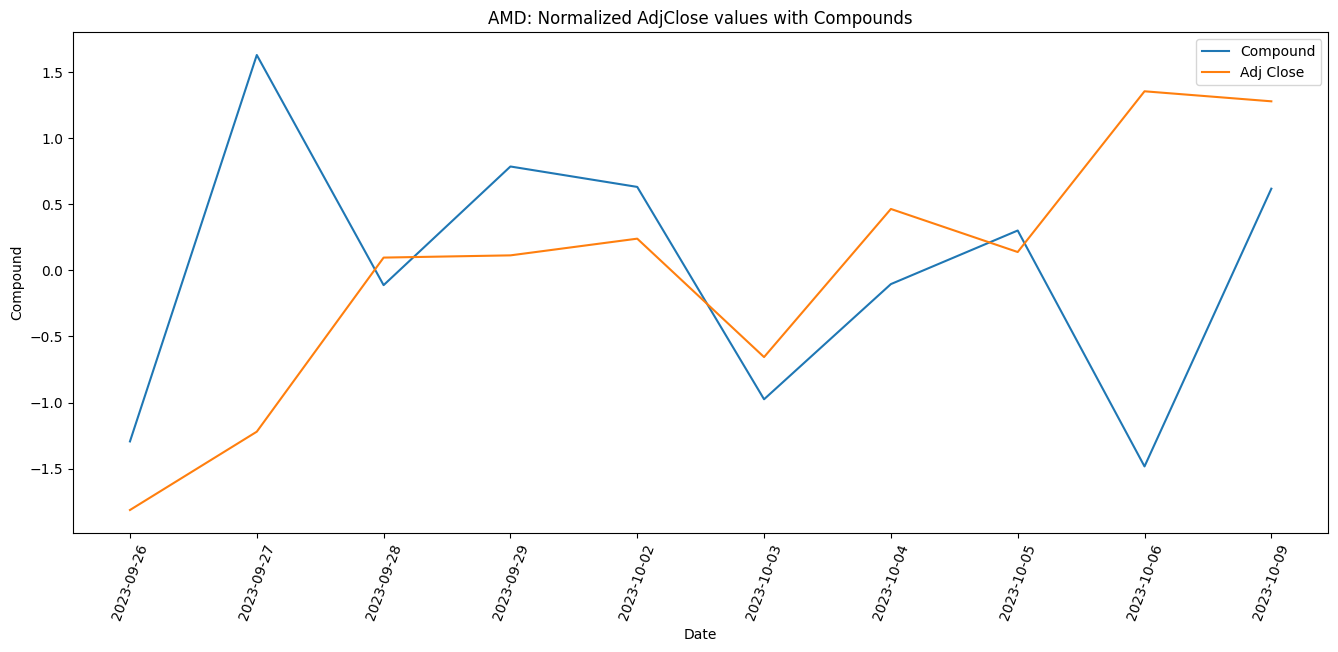

In [ ]:
company_compound_adjclose_normalized('AMD', amd_combinated_dataframe)

In [ ]:
pd.options.display.float_format = '{:,.3f}'.format
amd_stock.corr()


<ipython-input-101-e737446efb79>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  amd_stock.corr()


,index,Open,High,Low,Close,Adj Close,Volume
index,1.000,0.425,0.427,0.428,0.427,0.427,0.148
Open,0.425,1.000,0.998,0.997,0.994,0.994,0.055
High,0.427,0.998,1.000,0.997,0.997,0.997,0.082
Low,0.428,0.997,0.997,1.000,0.998,0.998,0.033
Close,0.427,0.994,0.997,0.998,1.000,1.000,0.059
Adj Close,0.427,0.994,0.997,0.998,1.000,1.000,0.059
Volume,0.148,0.055,0.082,0.033,0.059,0.059,1.000


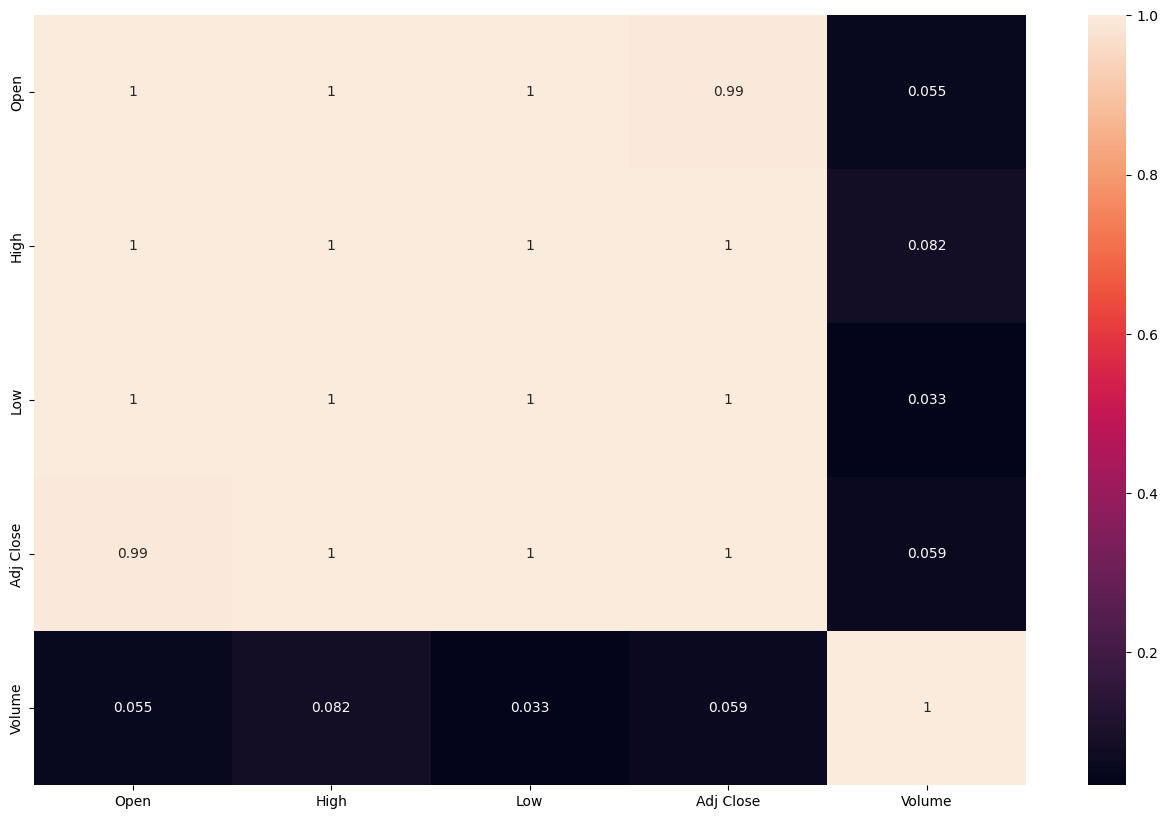

In [ ]:

plt.figure(figsize=(16, 10))
sns.heatmap(amd_stock[['Open', 'High', 'Low', 'Adj Close', 'Volume']].corr(), annot=True)
plt.show()